In [1]:
using GoldGates
using MSSim: Optimizers as Opts, SegSeq as SS, SymLinear as SL, Sequence as Seq, Utils as U
using BenchmarkTools
using NLopt
using Statistics
using PyPlot
using JSON
ENV["MPLBACKEND"] = "module://matplotlib_inline.backend_inline"

"module://matplotlib_inline.backend_inline"

In [ ]:
sysparams = open("../system_params/072125_goldparams_13ions.json") do io
    read(io, GoldGates.SystemParams; format=:json)
end;

In [3]:
# Constants across notebook
const nions = 13

# Objective function for optimization
function _objfunc(vals)
    dis = vals[1]
    disδ = vals[2]
    area = vals[3]
    areaδ = vals[4]
    τ = vals[5]

    return 5 * dis + disδ / 100 + (abs(area) - π / 2)^2 * 100 + (areaδ / 1e4)^2
end
const objfunc = Opts.autodiff(_objfunc);
const modes = Seq.Modes()
const nions = 13
const ion1 = 5
const ion2 = 9
for i in 1:nions
    push!(modes, 2π * sysparams.modes.radial1[i], sysparams.participation_factors[i][ion1] * sysparams.participation_factors[i][ion2] * sysparams.lamb_dicke_parameters[i]^2)
end

In [4]:
function make_base_funcs_tuple(n::Integer; atol::Real = 1e-12)
    # our amplitude base functions are a list of functions where the first function returns
    # 1 for all grid points, the second function returns 1 for all but the first & last points...
    @assert n ≥ 1 "n must be at least 1"
    m = n + 1
    # these are the same grid points that transform_argument will evaluate
    grid = [((i - 1) / (n / 2) - 1) for i in 1:m]
    fs_vec = [
        let k = k, grid = grid, m = m, atol = atol
            x -> begin
                exclude = k - 1
                lo = 1 + exclude
                hi = m - exclude
                if lo > hi
                    return 0.0
                end
                for j in lo:hi
                    if isapprox(x, grid[j]; atol = atol)
                        return 1.0
                    end
                end
                return 0.0
            end
        end for k in 1:cld(n+1, 2)
    ]
    return tuple(fs_vec...)
end

make_base_funcs_tuple (generic function with 1 method)

In [ ]:
nseg = 25
buf_opt = SL.ComputeBuffer{nseg,Float64}(Val(SS.mask_allδ), Val(SS.mask_allδ));
buf_plot = SL.ComputeBuffer{nseg,Float64}(Val(SS.mask_full), Val(SS.mask_full));

amp_funcs = make_base_funcs_tuple(nseg);
const nlmodel = Seq.Objective(SL.pmask_full,
    ((:dis2, 0), (:disδ2, 0), (:area, 0),
        (:areaδ, 0), (:τ, 0)),
    objfunc, modes, buf_opt,
    freq=Seq.FreqSpec(false, sym=true),    # turn off frequency modulation
    amp=Seq.AmpSpec(cb=amp_funcs, sym=true));

Ωmax is 0.15707963267948966
Total gate time is between 105 and 1750 us
  0.094869 seconds (1.66 k allocations: 411.781 KiB)
  0.097304 seconds (2.02 k allocations: 502.031 KiB)
  0.015968 seconds (300 allocations: 71.531 KiB)
  0.043090 seconds (793 allocations: 194.781 KiB)
  0.045747 seconds (936 allocations: 230.531 KiB)
  0.063727 seconds (1.08 k allocations: 263.297 KiB, 6.35% gc time)
  0.062756 seconds (1.10 k allocations: 271.203 KiB)
  0.151382 seconds (2.88 k allocations: 715.781 KiB)
(obj = 0.0003984498968552016, dis = 6.846100409589731e-9, disδ = 0.01976469302271473, area = 1.5707914821413183, areaε = -4.844653578306435e-6, areaδ = -141.69205660839884, total_t = 1644.3089135038497, Ωmax = 0.0)
  0.075354 seconds (1.25 k allocations: 308.781 KiB)
  0.104356 seconds (2.04 k allocations: 507.531 KiB)
  0.094991 seconds (1.53 k allocations: 378.781 KiB)
(obj = 0.00037331346883668677, dis = 1.0264038295423964e-9, disδ = 0.0011563183002902481, area = 1.5707940880965299, areaε = -

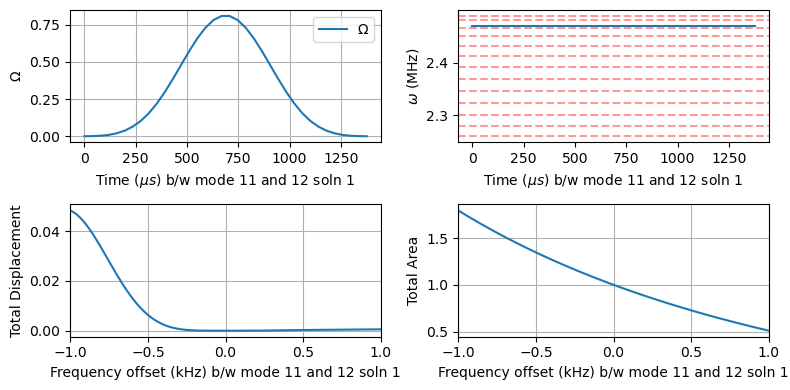

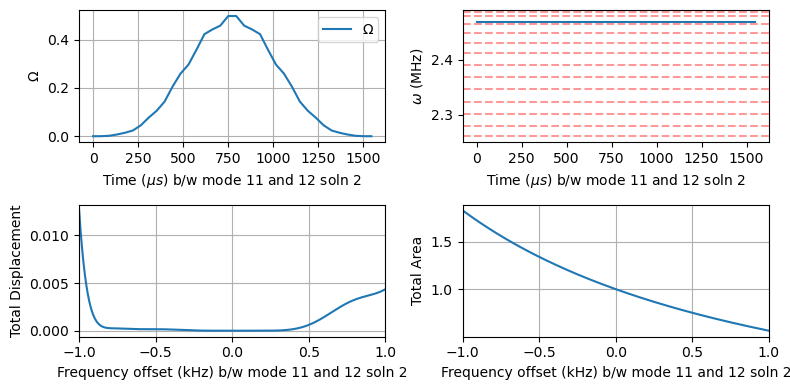

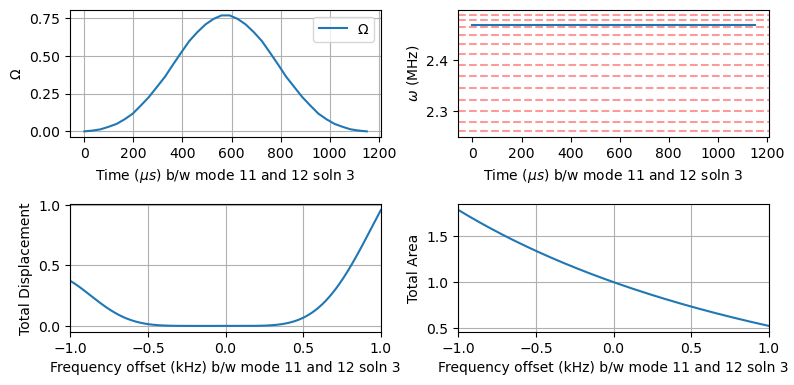

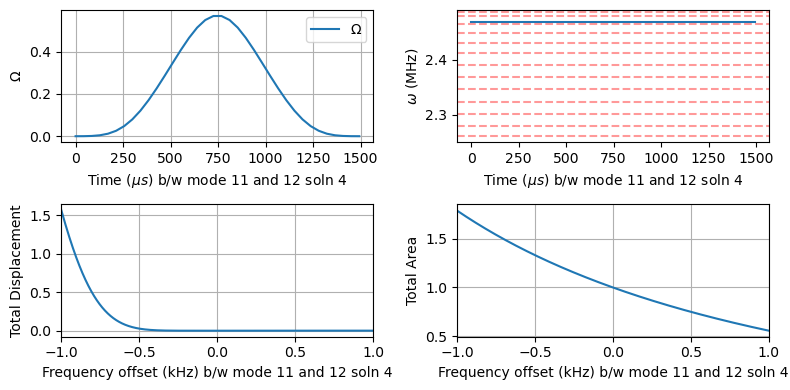

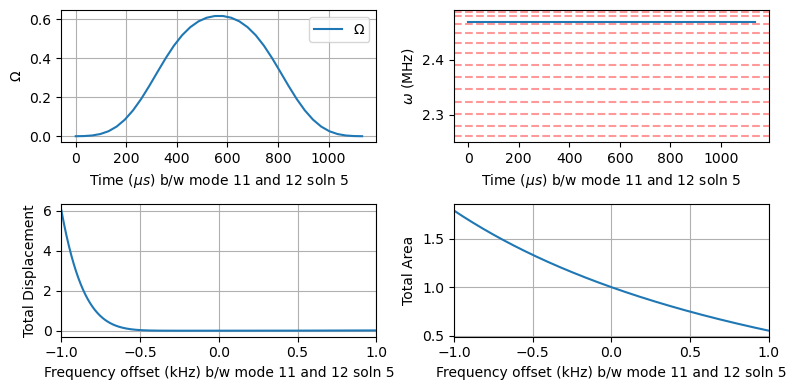

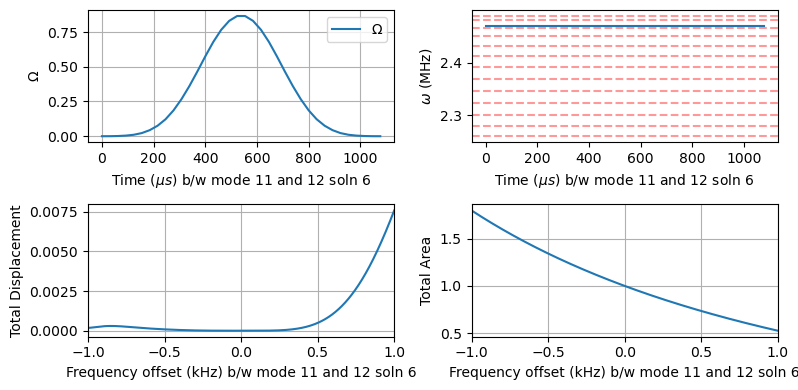

In [ ]:
mode = 11
for k in 1:6
    best_obj = Inf
    best_params = nothing
    threshold = -Inf  # not setting a threshold

    # Set bounds for optimizer
    pitime_to_Ω(time) = π / (2 * time)
    # this isn't a direct limit on rabi frequency though, just amplitude of each base function

    Ωmax = pitime_to_Ω(10)
    τmin = 3
    τmax = 30
    ωmin = 2π * (sysparams.modes.radial1[mode] + 0.002)
    ωmax = 2π * (sysparams.modes.radial1[mode + 1] - 0.002)

    nargs = Seq.nparams(nlmodel)
    tracker = Opts.NLVarTracker(nargs)
    for Ω in nlmodel.param.Ωs
        # set the rabi frequency bound on all amplitude base function
        Opts.set_bound!(tracker, Ω, 0, Ωmax)
    end
    println("Ωmax is $Ωmax")

    Opts.set_bound!(tracker, nlmodel.param.τ, τmin, τmax)
    println("Total gate time is between $(τmin * nseg) and $(τmax * nseg) us")

    for ω in nlmodel.param.ωs
        Opts.set_bound!(tracker, ω, ωmin, ωmax)
    end

    opt = NLopt.Opt(:LD_LBFGS, nargs)
    NLopt.min_objective!(opt, nlmodel)
    NLopt.lower_bounds!(opt, Opts.lower_bounds(tracker))
    NLopt.upper_bounds!(opt, Opts.upper_bounds(tracker))
    NLopt.maxtime!(opt, 10)


    @time for i in 1:200
        best_obj, best_params
        initial_params = Opts.init_vars!(tracker)
        obj, params, ret = @time NLopt.optimize(opt, initial_params)
        if getfield(NLopt, ret) < 0
            continue
        end
        if obj < best_obj
            best_obj = obj
            area = nlmodel(Val((:area, 0)), params)
            best_status = (
                obj = obj,
                dis = nlmodel(Val((:dis2, 0)), params),
                disδ = nlmodel(Val((:disδ2, 0)), params),
                area = area,
                areaε = abs(area) - π / 2,
                areaδ = nlmodel(Val((:areaδ, 0)), params),
                total_t = nlmodel(Val((:τ, 0)), params),
                Ωmax = params[nlmodel.param.Ωs[1]],
            )
            println(best_status)
            best_params = params
        end
        if best_obj < threshold
            break
        end
    end

    opt_raw_params = Seq.RawParams(nlmodel, best_params)
    kern = SL.Kernel(buf_plot, Val(SL.pmask_full));

    fig, axes = subplots(2, 2, figsize=(8, 4))

    ts, Ωs = Seq.get_Ωs(opt_raw_params)
    axes[1].plot(ts, Ωs, label="Ω")
    axes[1].set_xlabel("Time (\$\\mu s\$) b/w mode $(mode) and $(mode+1) soln $(k)")
    axes[1].set_ylabel(raw"$\Omega$")
    axes[1].grid(true)
    axes[1].legend()

    plot_δs = range(-1, 1, 10001); # kHz
    axes[2].plot(plot_δs, [Seq.total_dis(kern, Seq.adjust(opt_raw_params, δ=2π * δ / 1000), modes) for δ in plot_δs])
    axes[2].set_xlim([-1, 1])
    axes[2].set_xlabel("Frequency offset (kHz) b/w mode $(mode) and $(mode+1) soln $(k)")
    axes[2].set_ylabel("Total Displacement")
    axes[2].grid(true)

    ts, ωs = Seq.get_ωs(opt_raw_params)
    axes[3].plot(ts, ωs ./ 2π)
    axes[3].set_xlabel("Time (\$\\mu s\$) b/w mode $(mode) and $(mode+1) soln $(k)")
    axes[3].set_ylabel(raw"$\omega$ (MHz)")
    for m in sysparams.modes.radial1
        axes[3].axhline(m, ls="--", color="red", alpha=0.4)
    end

    area0 = Seq.total_area(kern, opt_raw_params, modes)
    axes[4].plot(plot_δs, [Seq.total_area(kern, Seq.adjust(opt_raw_params, δ=2π * δ / 1000), modes) / area0 for δ in plot_δs])
    axes[4].set_xlim([-1, 1])
    axes[4].set_xlabel("Frequency offset (kHz) b/w mode $(mode) and $(mode+1) soln $(k)")
    axes[4].set_ylabel("Total Area")
    axes[4].grid(true)
    tight_layout()

    total_gate_time = best_params[nlmodel.param.τ] * nseg
    total_dis = Seq.total_dis(kern, opt_raw_params, modes)
    total_cumdis = Seq.total_cumdis(kern, opt_raw_params, modes)
    total_disδ = Seq.total_disδ(kern, opt_raw_params, modes)
    total_areaδ = Seq.total_areaδ(kern, opt_raw_params, modes)
    enclosed_area = Seq.total_area(kern, opt_raw_params, modes)
    metadata = Dict(
        "total_gate_time" => total_gate_time,
        "total_displacement" => total_dis,
        "total_cumulative_displacement" => total_cumdis,
        "gradient_displacement_detuning" => total_disδ,
        "enclosed_area" => area0,
        "gradient_area_detuning" => total_areaδ,
        "carrier_pi_time_required" => π/maximum(Ωs)/2,
    )
    metadata_str = JSON.json(metadata)
    println(JSON.json(metadata, 4))

    _ion1 = ion1 - (nions + 1) ÷ 2
    _ion2 = ion2 - (nions + 1) ÷ 2
    solution_set = GoldGates.GateSolutionSet(params=sysparams,
        XX=Dict("$_ion2,$_ion1" => GoldGates.XXSolution(opt_raw_params, enclosed_area, metadata=metadata_str)))
    open("../out/freq_lim/mode$(mode)_$(mode+1)_$(k).json", "w") do io
        write(io, solution_set, format=:json)
    end

end
